In [1]:
from __future__ import print_function

print(__doc__)

# 引入必要的模型和库
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# 创建一个随机的数据集
# 参考 https://docs.scipy.org/doc/numpy-1.6.0/reference/generated/numpy.random.mtrand.RandomState.html
rng = np.random.RandomState(1)
# print 'lalalalala===', rng
# rand() 是给定形状的随机值，rng.rand(80, 1)即矩阵的形状是 80行，1列
# sort() 
X = np.sort(5 * rng.rand(80, 1), axis=0)
# print 'X=', X
y = np.sin(X).ravel()
# print 'y=', y
y[::5] += 3 * (0.5 - rng.rand(16))
# print 'yyy=', y

# 拟合回归模型
# regr_1 = DecisionTreeRegressor(max_depth=2)
# 保持 max_depth=5 不变，增加 min_samples_leaf=6 的参数，效果进一步提升了
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_2 = DecisionTreeRegressor(min_samples_leaf=6)
# regr_3 = DecisionTreeRegressor(max_depth=4)
# regr_1.fit(X, y)
regr_2.fit(X, y)
# regr_3.fit(X, y)

# 预测
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
# y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
# y_3 = regr_3.predict(X_test)

# 绘制结果
plt.figure()
plt.scatter(X, y, c="darkorange", label="data")
# plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
# plt.plot(X_test, y_3, color="red", label="max_depth=3", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Automatically created module for IPython interactive environment


<Figure size 640x480 with 1 Axes>

In [2]:
from __future__ import print_function
print(__doc__)
from numpy import *


# 默认解析的数据是用tab分隔，并且是数值类型
# general function to parse tab -delimited floats
def loadDataSet(fileName):
    """loadDataSet(解析每一行，并转化为float类型)
        Desc：该函数读取一个以 tab 键为分隔符的文件，然后将每行的内容保存成一组浮点数
    Args:
        fileName 文件名
    Returns:
        dataMat 每一行的数据集array类型
    Raises:
    """
    # 假定最后一列是结果值
    # assume last column is target value
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        # 将所有的元素转化为float类型
        # map all elements to float()
        # map() 函数具体的含义，可见 https://my.oschina.net/zyzzy/blog/115096
        fltLine = map(float, curLine)
        dataMat.append(fltLine)
    return dataMat


def binSplitDataSet(dataSet, feature, value):
    """binSplitDataSet(将数据集，按照feature列的value进行 二元切分)
        Description：在给定特征和特征值的情况下，该函数通过数组过滤方式将上述数据集合切分得到两个子集并返回。
    Args:
        dataMat 数据集
        feature 待切分的特征列
        value 特征列要比较的值
    Returns:
        mat0 小于等于 value 的数据集在左边
        mat1 大于 value 的数据集在右边
    Raises:
    """
    # # 测试案例
    # print 'dataSet[:, feature]=', dataSet[:, feature]
    # print 'nonzero(dataSet[:, feature] > value)[0]=', nonzero(dataSet[:, feature] > value)[0]
    # print 'nonzero(dataSet[:, feature] <= value)[0]=', nonzero(dataSet[:, feature] <= value)[0]

    # dataSet[:, feature] 取去每一行中，第1列的值(从0开始算)
    # nonzero(dataSet[:, feature] > value)  返回结果为true行的index下标
    mat0 = dataSet[nonzero(dataSet[:, feature] <= value)[0], :]
    mat1 = dataSet[nonzero(dataSet[:, feature] > value)[0], :]
    return mat0, mat1


# 返回每一个叶子结点的均值
# returns the value used for each leaf
# 我的理解是：regLeaf 是产生叶节点的函数，就是求均值，即用聚类中心点来代表这类数据
def regLeaf(dataSet):
    return mean(dataSet[:, -1])


# 计算总方差=方差*样本数
# 我的理解是：求这组数据的方差，即通过决策树划分，可以让靠近的数据分到同一类中去
def regErr(dataSet):
    # shape(dataSet)[0] 表示行数
    return var(dataSet[:, -1]) * shape(dataSet)[0]


# 1.用最佳方式切分数据集
# 2.生成相应的叶节点
def chooseBestSplit(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    """chooseBestSplit(用最佳方式切分数据集 和 生成相应的叶节点)
    Args:
        dataSet   加载的原始数据集
        leafType  建立叶子点的函数
        errType   误差计算函数(求总方差)
        ops       [容许误差下降值，切分的最少样本数]。
    Returns:
        bestIndex feature的index坐标
        bestValue 切分的最优值
    Raises:
    """

    # ops=(1,4)，非常重要，因为它决定了决策树划分停止的threshold值，被称为预剪枝（prepruning），其实也就是用于控制函数的停止时机。
    # 之所以这样说，是因为它防止决策树的过拟合，所以当误差的下降值小于tolS，或划分后的集合size小于tolN时，选择停止继续划分。
    # 最小误差下降值，划分后的误差减小小于这个差值，就不用继续划分
    tolS = ops[0]
    # 划分最小 size 小于，就不继续划分了
    tolN = ops[1]
    # 如果结果集(最后一列为1个变量)，就返回退出
    # .T 对数据集进行转置
    # .tolist()[0] 转化为数组并取第0列
    if len(set(dataSet[:, -1].T.tolist()[0])) == 1: # 如果集合size为1，也就是说全部的数据都是同一个类别，不用继续划分。
        #  exit cond 1
        return None, leafType(dataSet)
    # 计算行列值
    m, n = shape(dataSet)
    # 无分类误差的总方差和
    # the choice of the best feature is driven by Reduction in RSS error from mean
    S = errType(dataSet)
    # inf 正无穷大
    bestS, bestIndex, bestValue = inf, 0, 0
    # 循环处理每一列对应的feature值
    for featIndex in range(n-1): # 对于每个特征
        # [0]表示这一列的[所有行]，不要[0]就是一个array[[所有行]]，下面的一行表示的是将某一列全部的数据转换为行，然后设置为list形式
        for splitVal in set(dataSet[:, featIndex].T.tolist()[0]):
            # 对该列进行分组，然后组内的成员的val值进行 二元切分
            mat0, mat1 = binSplitDataSet(dataSet, featIndex, splitVal)
            # 判断二元切分的方式的元素数量是否符合预期
            if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN):
                continue
            newS = errType(mat0) + errType(mat1)
            # 如果二元切分，算出来的误差在可接受范围内，那么就记录切分点，并记录最小误差
            # 如果划分后误差小于 bestS，则说明找到了新的bestS
            if newS < bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    # 判断二元切分的方式的元素误差是否符合预期
    # if the decrease (S-bestS) is less than a threshold don't do the split
    if (S - bestS) < tolS:
        return None, leafType(dataSet)
    mat0, mat1 = binSplitDataSet(dataSet, bestIndex, bestValue)
    # 对整体的成员进行判断，是否符合预期
    # 如果集合的 size 小于 tolN 
    if (shape(mat0)[0] < tolN) or (shape(mat1)[0] < tolN): # 当最佳划分后，集合过小，也不划分，产生叶节点
        return None, leafType(dataSet)
    return bestIndex, bestValue


# assume dataSet is NumPy Mat so we can array filtering
# 假设 dataSet 是 NumPy Mat 类型的，那么我们可以进行 array 过滤
def createTree(dataSet, leafType=regLeaf, errType=regErr, ops=(1, 4)):
    """createTree(获取回归树)
        Description：递归函数：如果构建的是回归树，该模型是一个常数，如果是模型树，其模型师一个线性方程。
    Args:
        dataSet      加载的原始数据集
        leafType     建立叶子点的函数
        errType      误差计算函数
        ops=(1, 4)   [容许误差下降值，切分的最少样本数]
    Returns:
        retTree    决策树最后的结果
    """
    # 选择最好的切分方式： feature索引值，最优切分值
    # choose the best split
    feat, val = chooseBestSplit(dataSet, leafType, errType, ops)
    # if the splitting hit a stop condition return val
    # 如果 splitting 达到一个停止条件，那么返回 val
    '''
    *** 最后的返回结果是最后剩下的 val，也就是len小于topN的集合
    '''
    if feat is None:
        return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    # 大于在右边，小于在左边，分为2个数据集
    lSet, rSet = binSplitDataSet(dataSet, feat, val)
    # 递归的进行调用，在左右子树中继续递归生成树
    retTree['left'] = createTree(lSet, leafType, errType, ops)
    retTree['right'] = createTree(rSet, leafType, errType, ops)
    return retTree


# 判断节点是否是一个字典
def isTree(obj):
    """
    Desc:
        测试输入变量是否是一棵树,即是否是一个字典
    Args:
        obj -- 输入变量
    Returns:
        返回布尔类型的结果。如果 obj 是一个字典，返回true，否则返回 false
    """
    return (type(obj).__name__ == 'dict')


# 计算左右枝丫的均值
def getMean(tree):
    """
    Desc:
        从上往下遍历树直到叶节点为止，如果找到两个叶节点则计算它们的平均值。
        对 tree 进行塌陷处理，即返回树平均值。
    Args:
        tree -- 输入的树
    Returns:
        返回 tree 节点的平均值
    """
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
    return (tree['left']+tree['right'])/2.0


# 检查是否适合合并分枝
def prune(tree, testData):
    """
    Desc:
        从上而下找到叶节点，用测试数据集来判断将这些叶节点合并是否能降低测试误差
    Args:
        tree -- 待剪枝的树
        testData -- 剪枝所需要的测试数据 testData 
    Returns:
        tree -- 剪枝完成的树
    """
    # 判断是否测试数据集没有数据，如果没有，就直接返回tree本身的均值
    if shape(testData)[0] == 0:
        return getMean(tree)

    # 判断分枝是否是dict字典，如果是就将测试数据集进行切分
    if (isTree(tree['right']) or isTree(tree['left'])):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
    # 如果是左边分枝是字典，就传入左边的数据集和左边的分枝，进行递归
    if isTree(tree['left']):
        tree['left'] = prune(tree['left'], lSet)
    # 如果是右边分枝是字典，就传入左边的数据集和左边的分枝，进行递归
    if isTree(tree['right']):
        tree['right'] = prune(tree['right'], rSet)

    # 上面的一系列操作本质上就是将测试数据集按照训练完成的树拆分好，对应的值放到对应的节点

    # 如果左右两边同时都不是dict字典，也就是左右两边都是叶节点，而不是子树了，那么分割测试数据集。
    # 1. 如果正确 
    #   * 那么计算一下总方差 和 该结果集的本身不分枝的总方差比较
    #   * 如果 合并的总方差 < 不合并的总方差，那么就进行合并
    # 注意返回的结果： 如果可以合并，原来的dict就变为了 数值
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet, rSet = binSplitDataSet(testData, tree['spInd'], tree['spVal'])
        # power(x, y)表示x的y次方；这时tree['left']和tree['right']都是具体数值
        errorNoMerge = sum(power(lSet[:, -1] - tree['left'], 2)) + sum(power(rSet[:, -1] - tree['right'], 2))
        treeMean = (tree['left'] + tree['right'])/2.0
        errorMerge = sum(power(testData[:, -1] - treeMean, 2))
        # 如果 合并的总方差 < 不合并的总方差，那么就进行合并
        if errorMerge < errorNoMerge:
            print("merging")
            return treeMean
        # 两个return可以简化成一个
        else:
            return tree
    else:
        return tree


# 得到模型的ws系数：f(x) = x0 + x1*featrue1+ x2*featrue2 ...
# create linear model and return coeficients
def modelLeaf(dataSet):
    """
    Desc:
        当数据不再需要切分的时候，生成叶节点的模型。
    Args:
        dataSet -- 输入数据集
    Returns:
        调用 linearSolve 函数，返回得到的 回归系数ws
    """
    ws, X, Y = linearSolve(dataSet)
    return ws


# 计算线性模型的误差值
def modelErr(dataSet):
    """
    Desc:
        在给定数据集上计算误差。
    Args:
        dataSet -- 输入数据集
    Returns:
        调用 linearSolve 函数，返回 yHat 和 Y 之间的平方误差。
    """
    ws, X, Y = linearSolve(dataSet)
    yHat = X * ws
    # print corrcoef(yHat, Y, rowvar=0)
    return sum(power(Y - yHat, 2))


 # helper function used in two places
def linearSolve(dataSet):
    """
    Desc:
        将数据集格式化成目标变量Y和自变量X，执行简单的线性回归，得到ws
    Args:
        dataSet -- 输入数据
    Returns:
        ws -- 执行线性回归的回归系数 
        X -- 格式化自变量X
        Y -- 格式化目标变量Y
    """
    m, n = shape(dataSet)
    # 产生一个关于1的矩阵
    X = mat(ones((m, n)))
    Y = mat(ones((m, 1)))
    # X的0列为1，常数项，用于计算平衡误差
    X[:, 1: n] = dataSet[:, 0: n-1]
    Y = dataSet[:, -1]

    # 转置矩阵*矩阵
    xTx = X.T * X
    # 如果矩阵的逆不存在，会造成程序异常
    if linalg.det(xTx) == 0.0:
        raise NameError('This matrix is singular, cannot do inverse,\ntry increasing the second value of ops')
    # 最小二乘法求最优解:  w0*1+w1*x1=y
    ws = xTx.I * (X.T * Y)
    return ws, X, Y


# 回归树测试案例
# 为了和 modelTreeEval() 保持一致，保留两个输入参数
def regTreeEval(model, inDat):
    """
    Desc:
        对 回归树 进行预测
    Args:
        model -- 指定模型，可选值为 回归树模型 或者 模型树模型，这里为回归树
        inDat -- 输入的测试数据
    Returns:
        float(model) -- 将输入的模型数据转换为 浮点数 返回
    """
    return float(model)


# 模型树测试案例
# 对输入数据进行格式化处理，在原数据矩阵上增加第0列，元素的值都是1，
# 也就是增加偏移值，和我们之前的简单线性回归是一个套路，增加一个偏移量
def modelTreeEval(model, inDat):
    """
    Desc:
        对 模型树 进行预测
    Args:
        model -- 输入模型，可选值为 回归树模型 或者 模型树模型，这里为模型树模型，实则为 回归系数
        inDat -- 输入的测试数据
    Returns:
        float(X * model) -- 将测试数据乘以 回归系数 得到一个预测值 ，转化为 浮点数 返回
    """
    n = shape(inDat)[1]
    X = mat(ones((1, n+1)))
    X[:, 1: n+1] = inDat
    # print X, model
    return float(X * model)


# 计算预测的结果
# 在给定树结构的情况下，对于单个数据点，该函数会给出一个预测值。
# modelEval是对叶节点进行预测的函数引用，指定树的类型，以便在叶节点上调用合适的模型。
# 此函数自顶向下遍历整棵树，直到命中叶节点为止，一旦到达叶节点，它就会在输入数据上
# 调用modelEval()函数，该函数的默认值为regTreeEval()
def treeForeCast(tree, inData, modelEval=regTreeEval):
    """
    Desc:
        对特定模型的树进行预测，可以是 回归树 也可以是 模型树
    Args:
        tree -- 已经训练好的树的模型
        inData -- 输入的测试数据，只有一行
        modelEval -- 预测的树的模型类型，可选值为 regTreeEval（回归树） 或 modelTreeEval（模型树），默认为回归树
    Returns:
        返回预测值
    """
    if not isTree(tree):
        return modelEval(tree, inData)
    # 书中写的是inData[tree['spInd']]，只适合inData只有一列的情况，否则会产生异常
    if inData[0, tree['spInd']] <= tree['spVal']:
        # 可以把if-else去掉，只留if里面的分支
        if isTree(tree['left']):
            return treeForeCast(tree['left'], inData, modelEval)
        else:
            return modelEval(tree['left'], inData)
    else:
        # 同上，可以把if-else去掉，只留if里面的分支
        if isTree(tree['right']):
            return treeForeCast(tree['right'], inData, modelEval)
        else:
            return modelEval(tree['right'], inData)


# 预测结果
def createForeCast(tree, testData, modelEval=regTreeEval):
    """
    Desc:
        调用 treeForeCast ，对特定模型的树进行预测，可以是 回归树 也可以是 模型树
    Args:
        tree -- 已经训练好的树的模型
        testData -- 输入的测试数据
        modelEval -- 预测的树的模型类型，可选值为 regTreeEval（回归树） 或 modelTreeEval（模型树），默认为回归树
    Returns:
        返回预测值矩阵
    """
    m = len(testData)
    yHat = mat(zeros((m, 1)))
    # print yHat
    for i in range(m):
        yHat[i, 0] = treeForeCast(tree, mat(testData[i]), modelEval)
        # print "yHat==>", yHat[i, 0]
    return yHat


if __name__ == "__main__":
    # 测试数据集
    testMat = mat(eye(4))
    print(testMat)
    print(type(testMat))
    mat0, mat1 = binSplitDataSet(testMat, 1, 0.5)
    print(mat0, '\n-----------\n', mat1)

    # # 回归树
    # myDat = loadDataSet('data/9.RegTrees/data1.txt')
    # # myDat = loadDataSet('data/9.RegTrees/data2.txt')
    # # print 'myDat=', myDat
    # myMat = mat(myDat)
    # # print 'myMat=',  myMat
    # myTree = createTree(myMat)
    # print myTree

    # # 1. 预剪枝就是：提起设置最大误差数和最少元素数
    # myDat = loadDataSet('data/9.RegTrees/data3.txt')
    # myMat = mat(myDat)
    # myTree = createTree(myMat, ops=(0, 1))
    # print myTree

    # # 2. 后剪枝就是：通过测试数据，对预测模型进行合并判断
    # myDatTest = loadDataSet('data/9.RegTrees/data3test.txt')
    # myMat2Test = mat(myDatTest)
    # myFinalTree = prune(myTree, myMat2Test)
    # print '\n\n\n-------------------'
    # print myFinalTree

    # # --------
    # # 模型树求解
    # myDat = loadDataSet('data/9.RegTrees/data4.txt')
    # myMat = mat(myDat)
    # myTree = createTree(myMat, modelLeaf, modelErr)
    # print myTree

    # # # 回归树 VS 模型树 VS 线性回归
    # trainMat = mat(loadDataSet('data/9.RegTrees/bikeSpeedVsIq_train.txt'))
    # testMat = mat(loadDataSet('data/9.RegTrees/bikeSpeedVsIq_test.txt'))
    # # # 回归树
    # myTree1 = createTree(trainMat, ops=(1, 20))
    # print myTree1
    # yHat1 = createForeCast(myTree1, testMat[:, 0])
    # print "--------------\n"
    # # print yHat1
    # # print "ssss==>", testMat[:, 1]
    # # corrcoef 返回皮尔森乘积矩相关系数
    # print "regTree:", corrcoef(yHat1, testMat[:, 1],rowvar=0)[0, 1]

    # # 模型树
    # myTree2 = createTree(trainMat, modelLeaf, modelErr, ops=(1, 20))
    # yHat2 = createForeCast(myTree2, testMat[:, 0], modelTreeEval)
    # print myTree2
    # print "modelTree:", corrcoef(yHat2, testMat[:, 1],rowvar=0)[0, 1]

    # # 线性回归
    # ws, X, Y = linearSolve(trainMat)
    # print ws
    # m = len(testMat[:, 0])
    # yHat3 = mat(zeros((m, 1)))
    # for i in range(shape(testMat)[0]):
    #     yHat3[i] = testMat[i, 0]*ws[1, 0] + ws[0, 0]
    # print "lr:", corrcoef(yHat3, testMat[:, 1],rowvar=0)[0, 1]

Automatically created module for IPython interactive environment
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
<class 'numpy.matrixlib.defmatrix.matrix'>
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 
-----------
 [[0. 1. 0. 0.]]


Automatically created module for IPython interactive environment


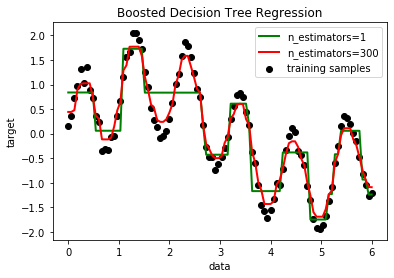

In [3]:
from __future__ import print_function

print(__doc__)

# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                          n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Plot the results
plt.figure()
plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()